In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 


### Boilerpalte

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "./sign_data/sign_data"]).decode("utf8"))

test
test_data.csv
train
train_data.csv



In [4]:
class Config():
    training_dir = "./sign_data/sign_data/train"
    testing_dir = "./sign_data/sign_data/test"
    train_batch_size = 16
    train_number_epochs = 10

In [5]:
training_dir="./sign_data/sign_data/train"
training_csv="./sign_data/sign_data/train_data.csv"
testing_csv="./sign_data/sign_data/test_data.csv"
testing_dir="./sign_data/sign_data/test"

In [6]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [7]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0.load()
        img1.load()

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [8]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [9]:
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


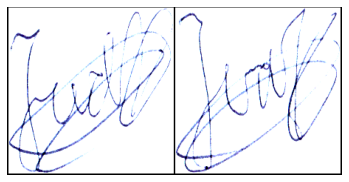

[[0.]]


In [10]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### ResNet Siamese

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 512),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.5),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [12]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

### Loss

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Train

In [14]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=Config.train_batch_size)

In [15]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [16]:
# Use
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.00005)

In [17]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 2.382411479949951

Epoch number 0
 Current loss 1.215120792388916

Epoch number 0
 Current loss 1.196221113204956

Epoch number 0
 Current loss 1.0805366039276123

Epoch number 0
 Current loss 1.5400184392929077

Epoch number 0
 Current loss 1.123150110244751

Epoch number 0
 Current loss 1.2131730318069458

Epoch number 0
 Current loss 1.2319862842559814

Epoch number 0
 Current loss 1.5112460851669312

Epoch number 0
 Current loss 1.1791644096374512

Epoch number 0
 Current loss 1.2454643249511719

Epoch number 0
 Current loss 1.204522967338562

Epoch number 0
 Current loss 1.1490015983581543

Epoch number 0
 Current loss 0.9007638692855835

Epoch number 0
 Current loss 1.074160099029541

Epoch number 0
 Current loss 1.2999298572540283

Epoch number 0
 Current loss 1.1419925689697266

Epoch number 0
 Current loss 0.6834629774093628

Epoch number 0
 Current loss 1.218949556350708

Epoch number 0
 Current loss 1.1451795101165771

Epoch number 0
 Current los

In [36]:
# # Load the saved model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [19]:
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,                                     transform=transform)

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [20]:
from tqdm import tqdm

In [21]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
threshhold = torch.FloatTensor([0.2]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1 , label = data
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        targets.append(1)
    else:
        targets.append(0)
    
    if eucledian_distance < threshhold:
        predictions.append(1)
    else:
        predictions.append(0)

100%|██████████| 5747/5747 [01:21<00:00, 70.85it/s]


In [22]:
from sklearn.metrics import f1_score

In [31]:
f1_score(n_targets, n_predictions, average='weighted')

0.9240827748937936

In [28]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.9243083347833653

In [35]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.156317689530686

In [34]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

0.8551260504201681

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


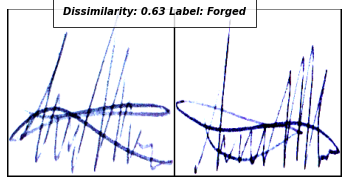

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


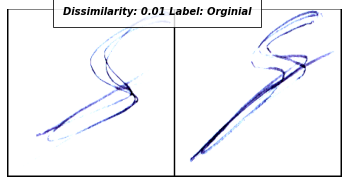

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


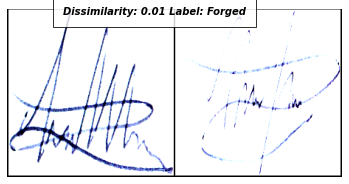

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


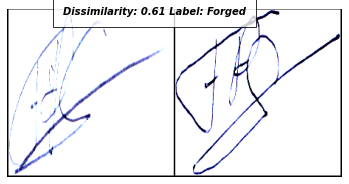

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


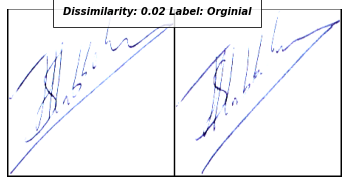

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


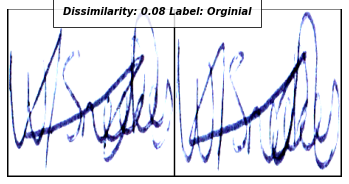

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


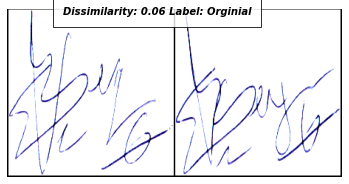

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


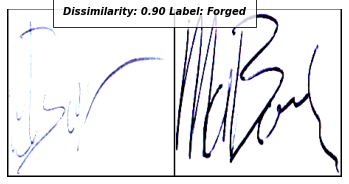

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


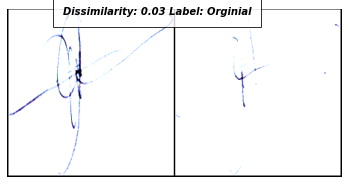

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


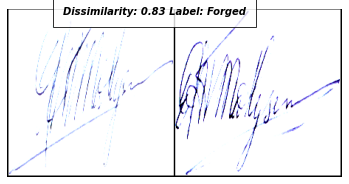

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


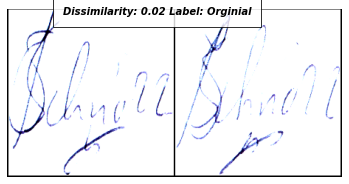

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


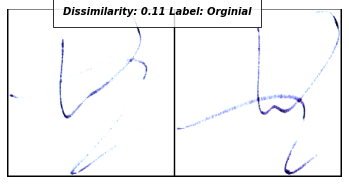

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


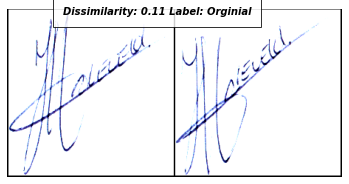

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


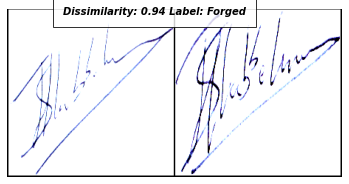

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


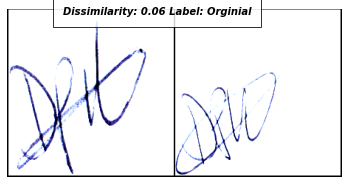

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


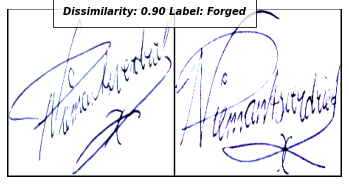

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


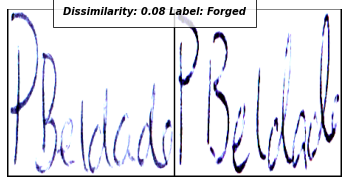

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


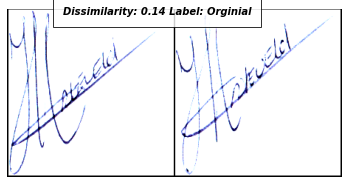

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


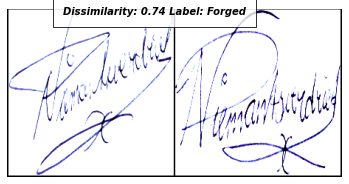

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


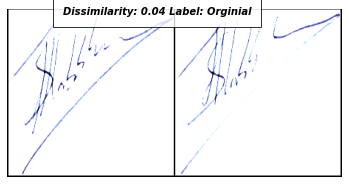

In [33]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [ ]:
# Gridsearch границы forged/original
# tiplet loss
# accuracy
# concat datasets

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Public kernel: https://www.kaggle.com/robinreni/signature-classification-using-siamese-pytorch 